##  2D population-based infarct personalization with CMA-ES
### Notebook corresponding to our article "Detailed evaluation of a population-wise personalization approach to generate synthetic myocardial infarct images", Pattern Recognition Letters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import time
from sklearn.manifold import Isomap
import pickle

In [2]:
from functions.generations import generate_elliptical, generate_spherical
from functions.data import data_preparation, weighted_center
from functions.loss import loss_function
from functions.cma import cmaes2D
from external.regression import MultiScaleKernelRidge

In [3]:
%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')

Note that the results in the article corresponded to the personalization to real infarct data, which cannot be publicly shared. As an alternative, we generated a similar number of synthetic samples using dimensionality reduction (with Isomap) and sampling from the latent space (with multiscale kernel ridge regression as decoder).

### 1. Data preparation

In [5]:
#the size of each infarct image is 80x80
numberPixels = 80

In [6]:
with open("Data.pkl", "rb") as f:
    realData = pickle.load(f)

We have 100 infarct cases to train models:

In [7]:
print(realData.shape)

(100, 80, 80)


Real coordinates of the grid of a 3D image:

In [8]:
with open("Coords.pkl", "rb") as f:
    coords = pickle.load(f)

Myocardial contents in 3D:

In [9]:
with open("Myocardium.pkl", "rb") as f:
    commonMyocardium = pickle.load(f)

In [10]:
center, myocardium, startZone, X0, Y0, X, Y, XR, XRLatent, indMyocardium = data_preparation(realData,coords,commonMyocardium)

The weighted **center** can be compared to the weighted center for the real population $[0.51159263,0.10012475]$, with this center we define the possible **startZone** to center the ellipse in the elliptical model or the first sphere in the iterative spherical model:

In [11]:
print(center)

[0.5083353  0.09954396]


We have the same size of the first dimension as for the real data for the vectors used in the computation of the loss function:

In [12]:
print(XR.shape)
print(XRLatent.shape)

(1890, 100)
(25, 100)


The start zone for this data is smaller (15 points vs 20 for the real population in the article):

In [13]:
print(X0.shape)

(15,)


In [14]:
print(X0)
print(Y0)

[22 22 23 21 22 23 21 22 20 21 22 20 21 22 21]
[29 30 30 31 31 31 32 32 33 33 33 34 34 34 35]


Some examples from the training set:

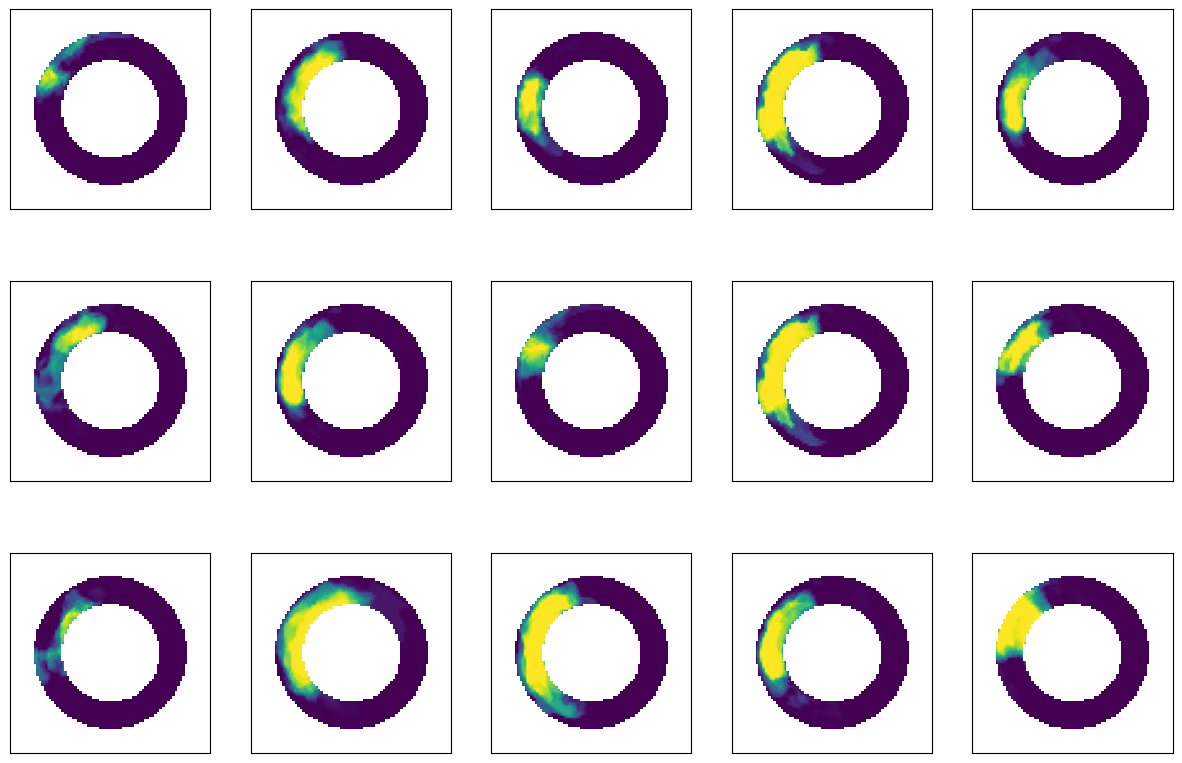

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(15,10))
for s, ax_s in enumerate(ax.flatten()):
    ax_s.imshow(realData[s,:,:])
    ax_s.set_xticklabels([])
    ax_s.set_yticklabels([])
    ax_s.xaxis.set_ticks_position('none')
    ax_s.yaxis.set_ticks_position('none')
plt.show()

### 2. Generations

Test the generation of the **elliptical model** with the parameters obtained from the individual-based personalization:

In [16]:
params = np.zeros(4)
params[0] = 22 #first mean
params[1] = 16 #second mean
params[2] = 16 #first std
params[3] = 11 #second std
numberCases = 15
Ie = generate_elliptical(params,numberCases,X0,Y0,X,Y,startZone,myocardium,numberPixels)

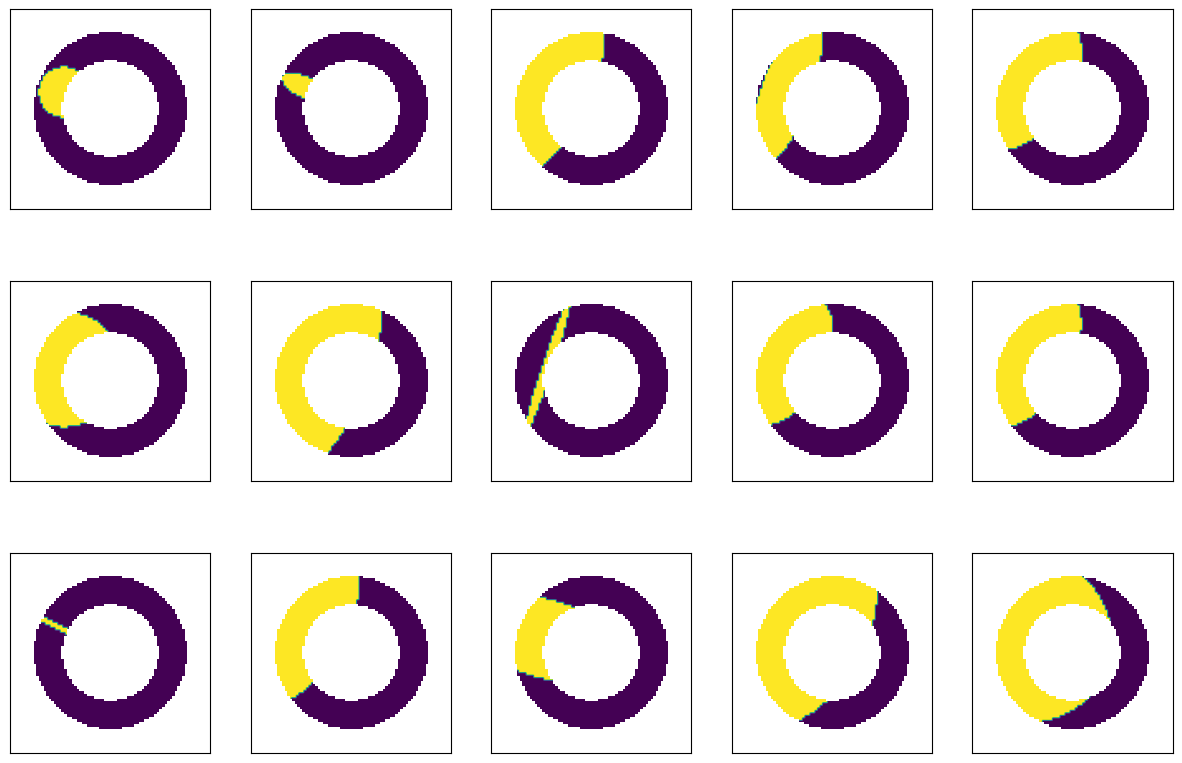

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(15,10))
for s, ax_s in enumerate(ax.flatten()):
    ax_s.imshow(Ie[:,:,s])
    ax_s.set_xticklabels([])
    ax_s.set_yticklabels([])
    ax_s.xaxis.set_ticks_position('none')
    ax_s.yaxis.set_ticks_position('none')
plt.show()

Test the generation of the **iterative model** with some parameters:

In [18]:
params = np.zeros(2)
params[0] = 5 #number of iterations
params[1] = 10 #max radius
numberCases = 15
Is = generate_spherical(params,numberCases,X0,Y0,X,Y,startZone,myocardium,numberPixels)

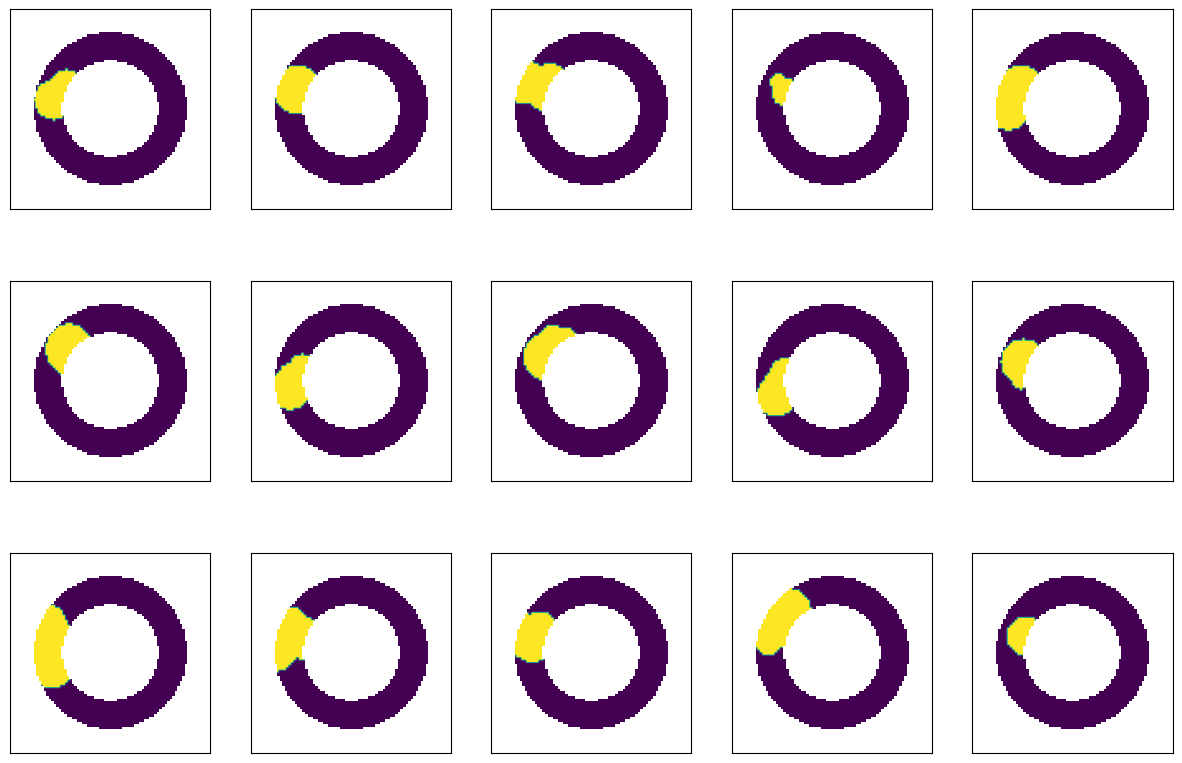

In [19]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(15,10))
for s, ax_s in enumerate(ax.flatten()):
    ax_s.imshow(Is[:,:,s])
    ax_s.set_xticklabels([])
    ax_s.set_yticklabels([])
    ax_s.xaxis.set_ticks_position('none')
    ax_s.yaxis.set_ticks_position('none')
plt.show()

### 3. Personalization

We can test the call of the loss function, we need to specify here and later in the optimization procedure **optionGeneration** to correspond to the iterative or elliptical model, and **optionLoss** to be the loss function on pixel data ($KL_{full}$) or based on infarct-related attributes ($KL_{attr}$). See the article for more details.

In [20]:
#Options: 1 = spherical iterative, 2 = elliptical
optionGeneration = 1
#Options: 1 = KL_full, 2 = KL_attr
optionLoss = 2
#number of generated infarcts for each parameter set
numberCases = 100
#for the kernel density estimation in the Kullback-Leibler divergence
knn = 9
if optionGeneration==1:
    #best params from the article
    params = np.zeros(2)
    params[0] = 1
    params[1] = 32
elif optionGeneration==2:
    #best params from the article
    params = np.zeros(4)
    params[0] = 18
    params[1] = 13
    params[2] = 10
    params[3] = 18
start = time.time()
loss = loss_function(optionGeneration,optionLoss,params,numberCases,XR,XRLatent,indMyocardium,knn,X0,Y0,X,Y,startZone,myocardium,numberPixels,coords)
end = time.time()
print('Execution time: ', end - start)
print('Loss: ', loss)

Execution time:  0.36892056465148926
Loss:  0.15137713859100801


We observe worse losses compare to the losses reported in the article for these parameters. 

Results are close to those of the article for the spherical iterative model and the elliptical model with $KL_{full}$, we ended up with the same behaviors in modes (to remind, in the article for the mean solutions for $KL_{attr}$ vs. $KL_{full}$: $(18,9,13,17)$ pixels vs. $(18,10,13,18)$ pixels for the elliptical model, $2$ iterations and radii of $21$ pixels vs. $1$ iterations and radii of $32$ pixels for the iterative model):

In [28]:
#Options: 1 = spherical, 2 = elliptical
optionGeneration = 2
#Options: 1 = KL_full, 2 = KL_attr
optionLoss = 1
if optionGeneration==1:
    #best initialization from the article and one selected for 3.2.4. Influence of the loss
    xStart = np.array([5,35])
elif optionGeneration==2:
    #best initialization from the article
    #xStart = np.array([22,16,10,20])
    #initialization selected for 3.2.4. Influence of the loss
    xStart = np.array([30,20,20,30])
numberParam = xStart.shape[0]
sigmaStart = 1
stopFitness = 0.004
numberCases = 100
knn = 9
stopEval = 500
lmbda = 15
xmin, outData, outDatx, outSigma, outD, J, t = cmaes2D(optionGeneration,optionLoss,numberCases,numberParam,xStart,sigmaStart,stopFitness,stopEval,lmbda,XR,XRLatent,indMyocardium,knn,X0,Y0,X,Y,startZone,myocardium,numberPixels,coords)
print('Execution time: ', t)

Passed time:  4.656010389328003  Function evaluations:  15
Passed time:  9.843060731887817  Function evaluations:  30
Passed time:  15.154717445373535  Function evaluations:  45
Passed time:  20.54201602935791  Function evaluations:  60
Passed time:  25.812665700912476  Function evaluations:  75
Passed time:  31.29487371444702  Function evaluations:  90
Passed time:  35.997801065444946  Function evaluations:  105
Passed time:  40.95767879486084  Function evaluations:  120
Passed time:  46.62527632713318  Function evaluations:  135
Passed time:  52.68842554092407  Function evaluations:  150
Passed time:  58.32655668258667  Function evaluations:  165
Passed time:  62.71243071556091  Function evaluations:  180
Passed time:  67.18503069877625  Function evaluations:  195
Passed time:  71.82066130638123  Function evaluations:  210
Passed time:  76.34287714958191  Function evaluations:  225
Passed time:  80.65271306037903  Function evaluations:  240
Passed time:  85.70274543762207  Function e

### 4. Visualization of results

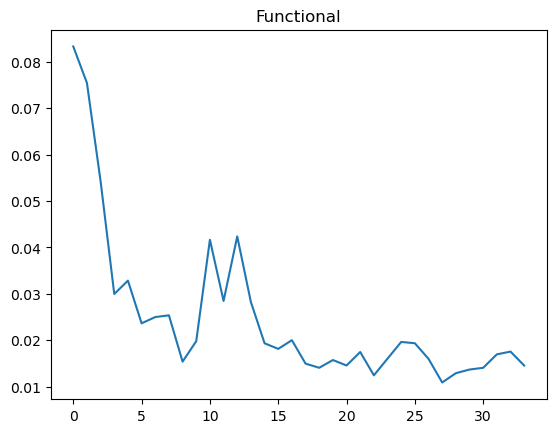

In [29]:
plt.plot(outData)
plt.title("Functional")
plt.show()

In [30]:
print('Array of losses: ',outData)

Array of losses:  [0.0832852973986008, 0.07543286164553968, 0.054256336280269254, 0.02997572966767373, 0.032855897160537266, 0.02366345909253123, 0.025008288324422034, 0.025383884709194976, 0.015406832485381355, 0.019813886150871082, 0.041664042143647224, 0.02848201771827899, 0.04237743472379666, 0.02823692543499899, 0.019364242991355682, 0.01815576597919233, 0.02002634839349443, 0.014983073077395798, 0.014082730570177976, 0.015753460220469036, 0.014578785438197947, 0.01748600169425507, 0.01246043500663388, 0.016058958004987682, 0.019647642044782865, 0.019372251331726327, 0.016006605406283757, 0.01091977972840176, 0.012920521422576096, 0.013704421051252379, 0.014083543660247874, 0.016976745396231632, 0.017572338519311212, 0.014564418906955388]


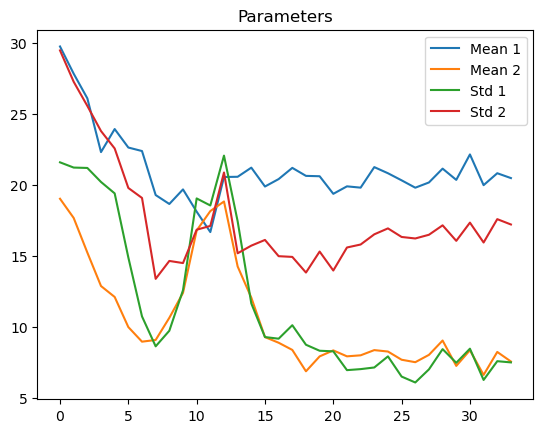

In [31]:
if optionGeneration==1:
    plt.plot(outDatx,label=['Iterations','Max radius'])
elif optionGeneration==2:
    plt.plot(outDatx,label=['Mean 1','Mean 2','Std 1','Std 2'])
plt.legend()
plt.title("Parameters")
plt.show()

To calculate the modes of variation:

In [32]:
def visualize_modes(J,numberCases,XR,realData,indMyocardium):
    #for MultiScaleKernelRidge
    gamma = 1
    knn = 5
    sigList = np.array([-2,-1,0,1,2])
    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig1, ax1 = plt.subplots(nrows=sigList.shape[0], ncols=3, figsize=(5, 8))
    fig2, ax2 = plt.subplots(nrows=sigList.shape[0], ncols=3, figsize=(5, 8))
    for pop in range(2):
        if pop==1:
            p = indMyocardium.shape[0]
            X = np.zeros((p,numberCases))
            for i in range(numberCases):
                tmp = J[:,:,i]
                for ip in range(p):
                    X[ip,i] = tmp[indMyocardium[ip,0],indMyocardium[ip,1]]
            color = 'blue'
            label = 'synthetic'
        else:
            p = indMyocardium.shape[0]
            nR = XR.shape[1]
            X = np.zeros((p,nR))
            for i in range(nR):
                tmp = realData[i,:,:]
                for ip in range(p):
                    X[ip,i] = tmp[indMyocardium[ip,0],indMyocardium[ip,1]]
            color = 'red'
            label = 'real'
        #Isomap characteristics
        components = 20
        neighbors = 5 
        embedding = Isomap(n_neighbors=neighbors, n_components=components)
        X_transformed = embedding.fit_transform(X.T)
        eig = embedding.kernel_pca_.eigenvalues_
        ax[0].plot(eig/eig[0],color=color,label=label)
        ax[1].plot(X_transformed[:,0],X_transformed[:,1],'o',color=color,label=label)
        TRAINING_X = X_transformed
        TRAINING_Y = X.T       
        #application of MultiScaleKernelRidge
        dimregression = 3
        for dim in range(dimregression):
            TESTING_X = np.zeros((sigList.shape[0],components))
            std = np.std(X_transformed[:,dim])
            for si in range(sigList.shape[0]):
                TESTING_X[si,dim] = std*sigList[si]
            mskr = MultiScaleKernelRidge(gamma=gamma, KNN=knn)
            mskr.fit(TRAINING_X, TRAINING_Y)
            TESTING_Y = mskr.predict(TESTING_X)
            if pop==1:
                for s in range(sigList.shape[0]):
                    tmp = np.empty((80,80))
                    tmp[:] = np.nan
                    for ip in range(p):
                        tmp[indMyocardium[ip,0],indMyocardium[ip,1]]=TESTING_Y[s,ip]
                    tmp[tmp>2] = 2
                    tmp[tmp<1] = 1
                    ax1[s,dim].imshow(tmp)
                    ax1[s,dim].set_xticklabels([])
                    ax1[s,dim].set_yticklabels([])
                    ax1[s,dim].xaxis.set_ticks_position('none')
                    ax1[s,dim].yaxis.set_ticks_position('none')
            else:
                for s in range(sigList.shape[0]):
                    tmp = np.empty((80,80))
                    tmp[:] = np.nan
                    for ip in range(p):
                        tmp[indMyocardium[ip,0],indMyocardium[ip,1]]=TESTING_Y[s,ip]
                    tmp[tmp>2] = 2
                    tmp[tmp<1] = 1
                    ax2[s,dim].imshow(tmp)
                    ax2[s,dim].set_xticklabels([])
                    ax2[s,dim].set_yticklabels([])
                    ax2[s,dim].xaxis.set_ticks_position('none')
                    ax2[s,dim].yaxis.set_ticks_position('none')
    ax[1].set_xlim([-150,150])
    ax[1].set_ylim([-150,150])
    ax[0].legend()
    ax[1].legend()
    ax.ravel()[0].set_title('Eigenvalues and first two latent dimesions')
    ax1.ravel()[0].set_title('Modes synthetic')
    ax2.ravel()[0].set_title('Modes real')
    plt.show()
    #ax1.ravel()[0].figure.savefig('Modessynthetic')
    #ax2.ravel()[0].figure.savefig('Modesreal')


scale: 0.000

scale: 1.000

scale: 2.000

scale: 3.000

scale: 4.000

scale: 5.000

scale: 0.000

scale: 1.000

scale: 2.000

scale: 3.000

scale: 4.000

scale: 5.000

scale: 0.000

scale: 1.000

scale: 2.000

scale: 3.000

scale: 4.000

scale: 5.000

scale: 0.000

scale: 1.000

scale: 2.000

scale: 3.000

scale: 4.000

scale: 5.000

scale: 0.000

scale: 1.000

scale: 2.000

scale: 3.000

scale: 4.000

scale: 5.000

scale: 0.000

scale: 1.000

scale: 2.000

scale: 3.000

scale: 4.000

scale: 5.000


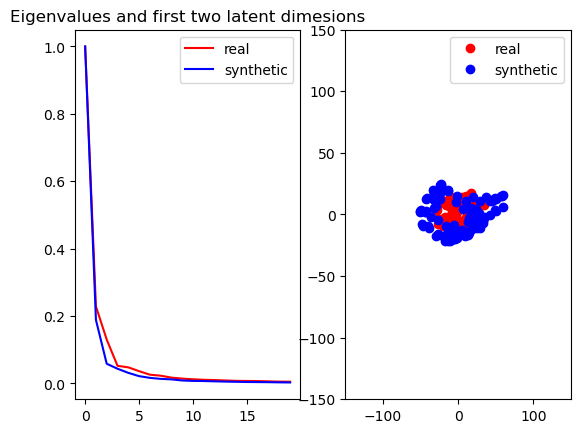

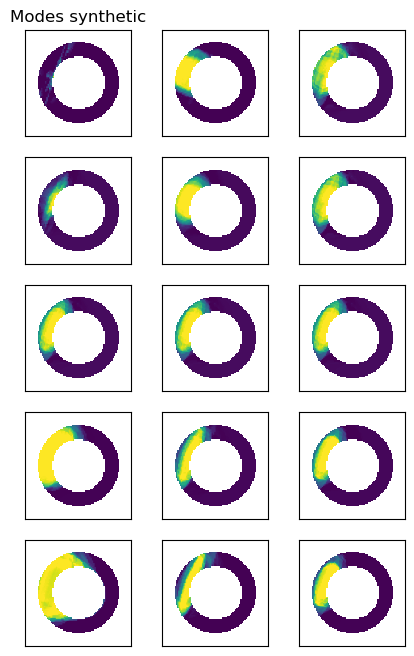

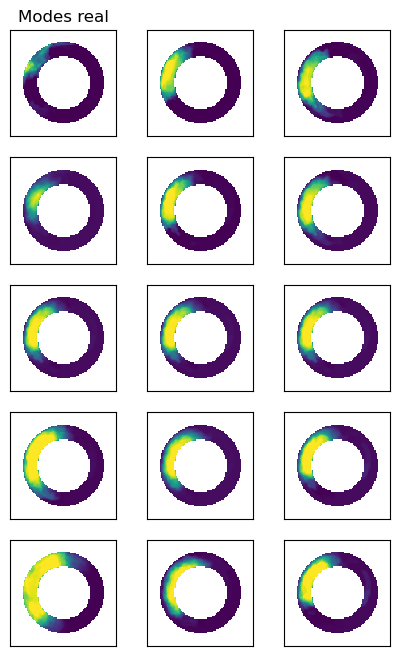

In [33]:
visualize_modes(J,numberCases,XR,realData,indMyocardium)